# Introduction

The project work implements the paper Students need more attention which mainly discusses on modifying Bi-directional Encoder Representations from Transformers(BERT) model to classify text data which are imbalanced and small. The general observation from authors is even though deep learning models like CNN, LSTM, BERT perform better than traditional models like SVM, linear regression they tend to overfit for use cases where the dataset is small and imbalanced.

**Problem:**

Deep learning models, like BERT, are powerful tools but require a vast amount of data for training.
In healthcare, datasets are often limited due to privacy concerns and the nature of medical information.
Small datasets can lead to overfitting, where the model performs well on the training data but poorly on unseen data.

**Proposed Solution:**

The paper introduces a novel framework called LESA-BERT (Label Embeddings for Self-Attention BERT). It builds upon BioBERT, a pre-trained model specifically for biomedical text mining. LESA-BERT incorporates two key elements:

**1. Label Embeddings for Self-Attention:** This injects label information into the self-attention mechanism of BERT at every layer. Self-attention allows the model to focus on important parts of the text relevant to the task. By including label information, the model can better learn patterns that differentiate between urgency levels in patient messages.

**2. Knowledge Distillation:** Large models like LESA-BERT can be prone to overfitting on small datasets. The paper addresses this by employing a technique called knowledge distillation. Here, a smaller "student" model is trained to mimic the predictions of the larger "teacher" model (BERT). This compressed student model inherits the knowledge of the teacher but with fewer parameters, reducing overfitting risks.


In [ ]:
# code comment is used as inline annotations for your coding

# Scope of Reproducibility:

List hypotheses from the paper you will test and the corresponding experiments you will run.


1.   Hypothesis 1:  Large models overfit to small imbalanced datasets.
2.   Hypothesis 2:  The proposed model provides better performance compared to other techniques such as vanilla BERT, CNN etc




# Methodology

The code base for the project is uploaded in a public github repo. The repo consists of data and model code used for training the model. Lets start by downloading the code repo

In [ ]:
# import  packages you need
! git clone https://github.com/aruncs2005/textclassifiers.git


##  Data
The data used in the paper is not openly available for further experiments. For this project we will use similar text classification datasets. We are using multiple datasets to test the models general- ization capabilities. Also using a different dataset from the original paper helps us to validate the hypothesis made by authors. Below are the datasets we use for this project
1. Medical-Abstracts-TC-Corpus - This repository contains a medical abstracts dataset, de- scribing 5 different classes of patient conditions including Neoplasms,Digestive system diseases, Nervous system diseases,Cardivascular diseases and General pathological conditions. The dataset can be used for text classification. The dataset can be found here - https://github.com/sebischair/Medical-Abstracts-TC-Corpus
2. Illness-dataset - the dataset consists of 22,660 documents (tweets) collected in 2018 and 2019. It spans across four domains: Alzheimer’s, Parkinson’s, Cancer, and Diabetes. We will reduce the number of samples to match the requirements depicted in the paper. The dataset can be found here - https://github.com/p-karisani/illness-dataset
3.PUBHEALTH - a comprehensive dataset for explainable automated fact-checking of public health claims. Each instance in the PUBHEALTH dataset has an associated veracity label (true, false, unproven, mixture). The dataset can be found here - https://github.com/neemakot/Health-Fact-Checking

For the draft we will work with the Medical-Abstract-TC-Corpus. The ideas we use for data curation will be similar for other datasets as well. Lets start with loading and printing the data statistics.

The dataset consists for 5 labels and the dataset is slightly imbalanced. Also we see each label has atleast 1000 samples. For preprocessing we will do the below

1.   Reduce the number of samples to approximately around 100
2.   Downsample data for some of the labels to make the dataset more imbalanced.
3. Filter out large texts to make sure we stick to the hypothesis.



In [ ]:
# dir and function to load raw data
import pandas as pd
raw_data_dir = 'textclassifiers/data/medabstracts/medical_tc_train.csv'

def load_raw_data(raw_data_dir):
  # implement this function to load raw data to dataframe/numpy array/tensor
  return pd.read_csv(raw_data_dir)

raw_data = load_raw_data(raw_data_dir)

# calculate statistics
def calculate_stats(raw_data):
  # implement this function to calculate the statistics
  # it is encouraged to print out the results
  return raw_data.groupby("condition_label").count()

# process raw data
def process_data(raw_data):
    # implement this function to process the data as you need
    sample = 500
    col_name = "condition_label"

    probs = raw_data[col_name].map(raw_data[col_name].value_counts())
    sampled_data = raw_data.sample(n=sample, weights=probs)
    return sampled_data

processed_data = process_data(raw_data)
print("The original data stats before preprocessing")
print(calculate_stats(raw_data))
print("The data stats after preprocessing")
print(calculate_stats(processed_data))


The dataset is reduce to 500 samples and the labels are also imbalanced especially label 2 and 3.

Save the dataset to be used for training

In [ ]:
processed_data.to_csv("textclassifiers/data/medabstracts/train.csv",index=False)

##   Model


The project uses BERT and its variations to test different hypothesis. BERT is a Decoder only Transformer Architecture and uses AutoEncoding objective for training. BERT is generally trained in 2 phases
1. Unsupervised Pretraining on Large corpus of Data, followed by
2. Fine tuning on supervised data like text classification, Question Answering etc.

BERT is pretrained on two unsupervised objectives

1) Masked LM - Here random input tokens are re- place by a < MASK > token and fed into the network. The goal is to learn from deep bidirectional context and predict the < MASK > tokens in the input sequence. The task uses cross entropy loss to compare predicted tokens with ground truth and update the model parameters

2) Next Sentence Prediction (NSP)- In order to make sure the model can be used on downstream tasks such as Ques- tion Answering which spans multiple sentences, BERT is trained to predict whether 2 sentences in a corpus occur one after the other. NSP uses cross entropy as loss function to update the model parameters.

BERT was trained on a large corpus of unstructed data spanning to 16 GB in size which included Book Corpus and English wikipedia. BERT was trained on 2 model sizes which includes BERT BASE (110 million Parameters) and BERT LARGE (340M parameters)

In this project we use BERT for text classification. The below image shows the high level architecture



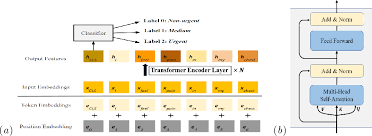




BERT model structure for text classification.Token and position embeddings are summed up as input embeddings, then fed through N transformer encoder layers, yielding a high-level representations (features) for classification.


The image below describes the usage of label embeddings along with BERT. This mainly consists of

(a) Incorporating label embeddings to the multi-head self-attention in BERT.

(b) Modifying self-attention scores with label embeddings. L indicates row concatenation


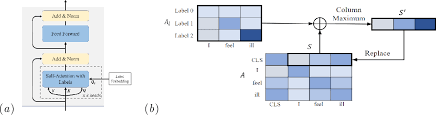



Lets take a look at the model code specifically for label embeddings. We modify the BERT layers such as embeddings, Attention to accomodate the addition of label embeddings. Below code block depicts the changes in each layer.

In [ ]:
# Embedding layer
#self.label_embeddings = nn.Parameter(torch.zeros(num_labels, config.hidden_size))#nn.Embedding(num_labels, config.hidden_size)

#Attention layer forward, combine label embeddings with query

# lb_embeddings = label_embeddings[label_ids]
# lb_embeddings = lb_embeddings.expand(batch_size, num_labels, hidden_size)
# mixed_lb_query = self.query(lb_embeddings)
# lb_query = self.transpose_for_scores(mixed_lb_query)

The model training cannot be conducted on a colab environment as it uses a specific versions of python and pytorch. We have build a docker file that can be used to create an environment and test the model training.

In [ ]:
# to build the docker environment , cd into the textclassifiers folder and run docker build .

# Note :  We need a machine that has docker setup to run the build. For running the build and training the model we used Amazon SageMaker Notebook instance with G4d 2xlarge instance.

# Please follow the below instructions to setup the code

# clone the repo
! git clone https://github.com/aruncs2005/textclassifiers.git

# build the docker image
! cd textclassifier && docker build .

# install nvidia container toolkit
# for AL2
! sudo yum install -y nvidia-container-toolkit

#for ubuntu
! sudo apt-get install -y nvidia-container-toolkit


# start the docker image

! docker run -it  --runtime=nvidia --gpus all -v <full_path_to>/text_classifiers:/workspace/text_classifiers <container_image_id>

# once you are in the container to start the training use

! bash run_bert.sh # for bert based training
! bash run_label_bert.sh # for label embeddings based training


# Results

We have used accuracy and F1 score to test the model. Below are the results when trained on 2 different settings

1. BERT Based Model


    acc = 0.8259803921568627
    acc_and_f1 = 0.8533263305322129
    f1 = 0.880672268907563


2. BERT with label embeddings


    acc = 0.8480392156862745
    acc_and_f1 = 0.8714772349617813
    f1 = 0.8949152542372881



## Model comparison

We can see that the label embeddings model performs slightly better than the plain BERT model. We will continue to test the variations with different dataasets.

# Discussion

The Draft only explores the label embeddings model that the original paper discusses and compares it with BERT based model. For the final submission we are looking to add the below features

1.   Implement other models like CNN based classifiers and distillbert to compare performances
2.  Test the hypothesis of model distillation lowers overfitting.
3. The codebase is currently running with older versions of torch and transformers. We couldn't get the updated version working for the draft. We will update and simplify the codebase.
4. Currently the codebase runs with a docker environment due to its dependencies on certain python and torch version. The upgrade will make sure to eliminate the need of docker builds.
5. We will use additional datasets mentioned above to run the tests.
6. Provide graphical evaluation results.



In [ ]:
# no code is required for this section
'''
if you want to use an image outside this notebook for explanaition,
you can read and plot it here like the Scope of Reproducibility
'''

## Video Presentation

The video explaining the paper and our experiments is uploaded in google drive and can be publicly accessed using the below link

https://drive.google.com/file/d/1iWARpnqWEWQ79NUqiNbt9Ms2hndyRUkR/view?usp=sharing

# References

1.   Sun, J, [paper title], [journal title], [year], [volume]:[issue], doi: [doi link to paper]

